# Hodgkin-Huxley example

In [10]:
%load_ext autoreload
%autoreload 2

import os
from typing import Any, Sequence
from copy import copy
import logging
logging.getLogger("absl").setLevel("WARNING")

import torch
import torch.utils.data as data

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import distrax 
import optax
import tensorflow_probability as tfp
tfp = tfp.substrates.jax
tfd = tfp.distributions

import sbi.utils as utils
import sbi.analysis as analysis
from sbi.inference import SNPE

from HH_helper_functions import syn_current, HHsimulator, calculate_summary_statistics

from jaxili.train import TrainerModule, TrainState
from jaxili.model import ConditionalMAF, ConditionalRealNVP
from jaxili.utils import create_data_loader

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
I, t_on, t_off, dt, t, A_soma = syn_current()

In [3]:
def run_HH_model(params):

    params = np.asarray(params)

    #input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    #initial voltage
    V0 = -70

    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [4]:
#three sets of g_Na, g_K)
params = np.array([[50.0, 1.0], [4.0, 1.5], [20.0, 15.0]])

num_samples = len(params[:, 0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i, :] = run_HH_model(params = params[i, :])["data"]

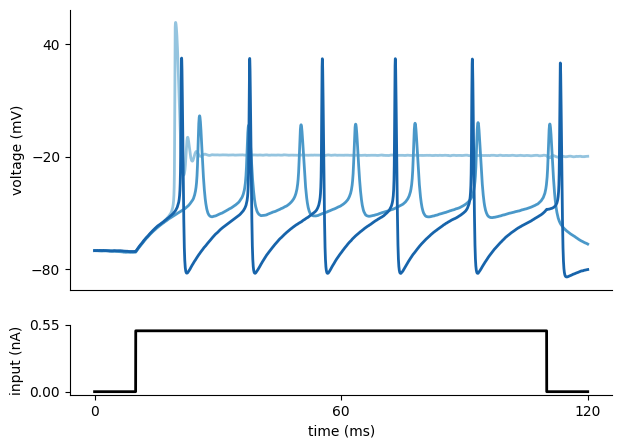

In [5]:
#colors for traces
col_min = 2

num_colors = num_samples + col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.0*i/num_colors) for i in range(col_min, num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t, sim_samples[i,:], color=col1[i], lw=2)
plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t, I*A_soma*1e3, "k", lw=2)
plt.xlabel("time (ms)")
plt.ylabel("input (nA)")

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
plt.show()

In [6]:
def simulation_wrapper(params):
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [7]:
prior_min = [0.5, 1e-4]
prior_max = [80.0, 15.0]
prior = utils.torchutils.BoxUniform(
    low = torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [8]:
thetas = prior.sample((300,))
xs = torch.stack([simulation_wrapper(theta) for theta in thetas])
xs = torch.as_tensor(xs, dtype=torch.float32)

In [9]:
print(thetas.shape, xs.shape)

torch.Size([300, 2]) torch.Size([300, 7])


In [11]:
inference = SNPE(prior, density_estimator='maf')

density_estimator = inference.append_simulations(thetas, xs).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 175 epochs.

In [12]:
type(density_estimator)

nflows.flows.base.Flow

In [13]:
true_params = np.array([50.0, 5.0])
labels_params = [r"$g_{Na}$", r"$g_{K}$"]

observation_trace = run_HH_model(true_params)
observation_summary_statistics = calculate_summary_statistics(observation_trace)

In [119]:
samples = posterior.sample((10000,), x=observation_summary_statistics)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [141]:
torch.mean(posterior.log_prob(samples, x=observation_summary_statistics))

tensor(-0.5965)

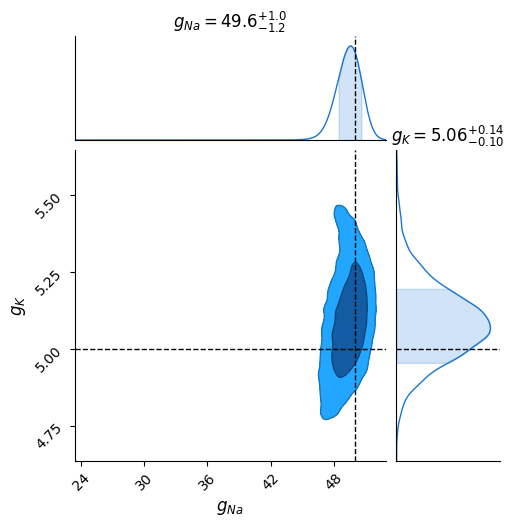

In [15]:
c = ChainConsumer()
c.add_chain(samples.numpy(), parameters=labels_params)
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()

In [16]:
#using jaxili

#Create the dataset
class HH_dataset(data.Dataset):
    def __init__(self, thetas, xs):
        self.thetas = thetas.numpy()
        self.xs = xs.numpy()

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]
    
    def set_params(self, thetas):
        self.thetas = thetas
    
    def set_data(self, xs):
        self.xs = xs
    
def generate_dataset(num_samples):
    thetas = prior.sample((num_samples,))
    xs = torch.stack([simulation_wrapper(theta) for theta in thetas])
    xs = torch.as_tensor(xs, dtype=torch.float32)
    return thetas, xs

train_set = HH_dataset(thetas, xs)
val_set = HH_dataset(*generate_dataset(100))
test_set = HH_dataset(*generate_dataset(200))

#Normalize the data
thetas, xs = train_set[:]
thetas_mean = thetas.mean(axis=0)
thetas_std = thetas.std(axis=0)
xs_mean = xs.mean(axis=0)
xs_std = xs.std(axis=0)
train_set.set_params((thetas - thetas_mean)/thetas_std)
train_set.set_data((xs - xs_mean)/xs_std)
thetas, xs = val_set[:]
val_set.set_params((thetas - thetas_mean)/thetas_std)
val_set.set_data((xs - xs_mean)/xs_std)
thetas, xs = test_set[:]
test_set.set_params((thetas - thetas_mean)/thetas_std)
test_set.set_data((xs - xs_mean)/xs_std)

#Create the model
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train=[True, False, False],
    batch_size=50
)

In [23]:
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_cond : int,
                 n_layers : int,
                 layers : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 activation : str = 'silu',
                 trial : Any = None,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_in,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'layers': layers,
                             'use_reverse': use_reverse,
                             'seed': seed,
                             'activation': activation,
                         },
                         
                         **kwargs)
        self.trial = trial
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output, updates = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  mutable=['batch_stats'], method='log_prob')
            return -jnp.mean(output), (output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            (loss, (updates)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss, _ = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def init_optimizer(self,
                       num_epochs : int,
                       num_steps_per_epoch : int):
        """
        Initializes the optimizer and learning rate scheduler.

        Parameters
        ----------
        num_epochs : Number of epochs to train.
        num_steps_per_epoch : Number of steps per epoch.
        """

        hparams = copy(self.optimizer_hparams)

        #Initialize optimizer
        optimizer_name = hparams.pop('optimizer_name', 'adam')
        if optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        elif optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        else:
            assert False, f'Unknown optimizer \"{optimizer_name}\"'
        #Initialize learning rate scheduler
        #A cosine decay scheduler is used, but others are also possible
        lr = hparams.pop('lr', 1e-3)
        warmup = hparams.pop('warmup', 0.1)
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=lr,
            warmup_steps=warmup,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=0.01 * lr
        )
        #Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip_by_global_norm(hparams.pop('gradient_clip', 5.0))]
        if opt_class == optax.sgd and 'weight_decay' in hparams:
            transf.append(optax.add_decayed_weights(hparams.pop('weight_decay', 0.0)))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **hparams)
        )
        #Initialize training state
        self.state = TrainState.create(
            apply_fn=self.state.apply_fn,
            params=self.state.params,
            batch_stats=self.state.batch_stats,
            tx=optimizer,
            rng=self.state.rng
        )
        
    def generate_config(self, logger_params):
        self.config = {
            'model_class': self.model_class.__name__,
            'model_hparams': copy(self.model_hparams),
            'optimizer_hparams': self.optimizer_hparams,
            'logger_params': logger_params,
            'enable_progress_bar': self.enable_progress_bar,
            'debug': self.debug,
            'check_val_every_epoch': self.check_val_every_epoch,
            'seed': self.seed
        }
        self.config['model_hparams']['prior'] = 'Uniform'
        
        
    def print_tabulate(self, exmp_input):
        pass

In [146]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints'

trainer = MAFTrainer(
    n_in=2,
    n_cond=7,
    n_layers=5,
    layers=[50, 50],
    use_reverse=True,
    seed=30,
    activation='relu',
    optimizer_hparams={
        'lr': 5e-2,
        'optimizer_name': 'adam',
    },
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    trial=None,
    debug=False
)

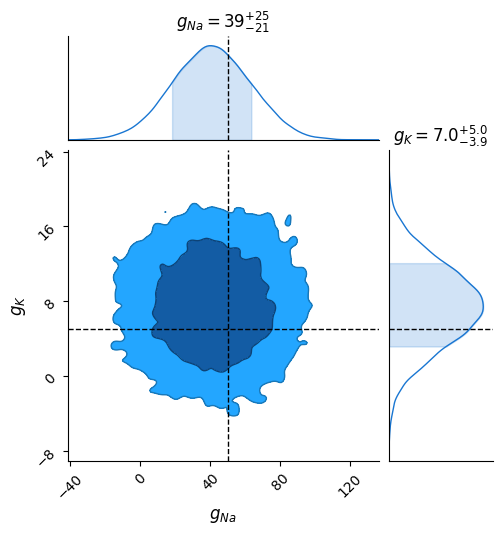

In [147]:
key = jax.random.PRNGKey(42)
pre_samples = trainer.model.apply(
    {'params': trainer.state.params}, (observation_summary_statistics.reshape((-1, 7))-xs_mean)/xs_std, num_samples=10000, key=key, method='sample'
)

c = ChainConsumer()
c.add_chain(pre_samples*thetas_std+thetas_mean, parameters=labels_params)
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()

In [148]:
trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epochs: Val loss 2.319/ Best val loss 2.319:   0%|          | 1/200 [00:07<24:33,  7.40s/it]/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py

Neural network training stopped after 153 epochs.
Early stopping with best validation metric: -3.366126537322998
Best model saved at epoch 132
Early stopping parameters: min_delta=0.001, patience=20


{'val/loss': -3.366126537322998,
 'train/loss': -3.929536819458008,
 'epoch_time': 0.043706417083740234,
 'test/loss': -2.067708730697632}

In [149]:
model = trainer.bind_model()

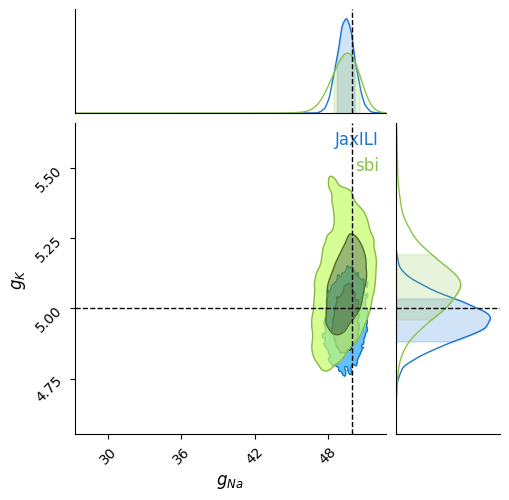

In [150]:
key = jax.random.PRNGKey(42)
jaxili_samples = model.sample((observation_summary_statistics.reshape((-1, 7))-xs_mean)/xs_std, num_samples=10000, key=key)

c = ChainConsumer()
c.add_chain(jaxili_samples*thetas_std+thetas_mean, parameters=labels_params, name="JaxILI")
c.add_chain(samples.numpy(), parameters=labels_params, name="sbi")
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()

In [138]:
log_prob = model.log_prob(jaxili_samples, (observation_summary_statistics.reshape((-1, 7))-xs_mean)/xs_std*jnp.ones((10000, 1)))

In [142]:
-jnp.mean(log_prob)-np.sum(np.log(1/thetas_mean))

Array(-3.4741566, dtype=float32)

## Neural Likelihood Estimation

In [36]:
class MAFTrainer_NLE(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_cond : int,
                 n_layers : int,
                 layers : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 activation : str = 'silu',
                 trial : Any = None,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_in,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'layers': layers,
                             'use_reverse': use_reverse,
                             'seed': seed,
                             'activation': activation,
                         },
                         
                         **kwargs)
        self.trial = trial
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output, updates = self.model.apply(
                {'params': params},
                  xs, thetas, train,
                  mutable=['batch_stats'], method='log_prob')
            return -jnp.mean(output), (output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            (loss, (updates)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss, _ = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step

    def run_model_init(self, exmp_input, init_rng):
        thetas, xs = exmp_input
        return self.model.init(init_rng, xs, thetas, train=True, method='log_prob')           
        
    def print_tabulate(self, exmp_input):
        pass

In [154]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints'

trainer = MAFTrainer_NLE(
    n_in=7,
    n_cond=2,
    n_layers=5,
    layers=[50, 50],
    use_reverse=True,
    seed=30,
    activation='relu',
    optimizer_hparams={
        'lr': 5e-3,
        'optimizer_name': 'adam'
    },
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    trial=None,
    debug=False
)

In [155]:
trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epochs: Val loss 10.504/ Best val loss 10.504:   0%|          | 1/200 [00:06<22:23,  6.75s/it]/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.

{'val/loss': -8.79733657836914,
 'train/loss': -11.51662826538086,
 'epoch_time': 0.03253459930419922,
 'test/loss': -9.39673137664795}

In [156]:
model = trainer.bind_model()

In [157]:
samples = model.sample(((true_params-thetas_mean)/thetas_std).reshape(-1, 2), num_samples=10000, key=key)

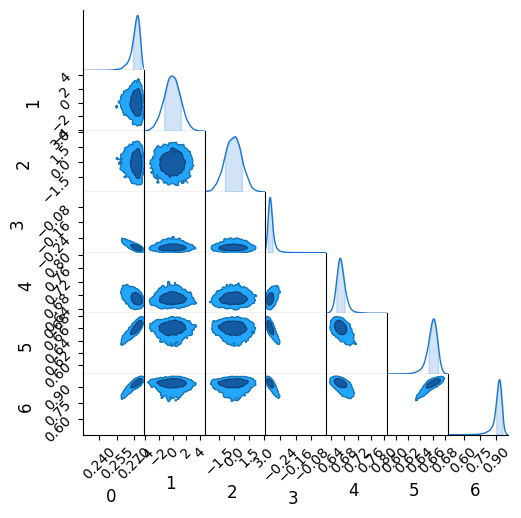

In [158]:
c = ChainConsumer()

c.add_chain(samples)
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()

In [159]:
def log_prob(thetas):
    return model.log_prob(((observation_summary_statistics.reshape(-1, 7)-xs_mean)/xs_std)*jnp.ones((len(thetas), 1)), (thetas-thetas_mean)/thetas_std)

In [160]:
from tqdm import tqdm

theta_1 = np.linspace(0.5, 80, 100)
theta_2 = np.linspace(1e-4, 15, 100)

theta_1, theta_2 = np.meshgrid(theta_1, theta_2)

theta_1 = theta_1.flatten()
theta_2 = theta_2.flatten()
thetas = np.stack([theta_1, theta_2], axis=1)
ll_value = log_prob(thetas).reshape((100, 100))

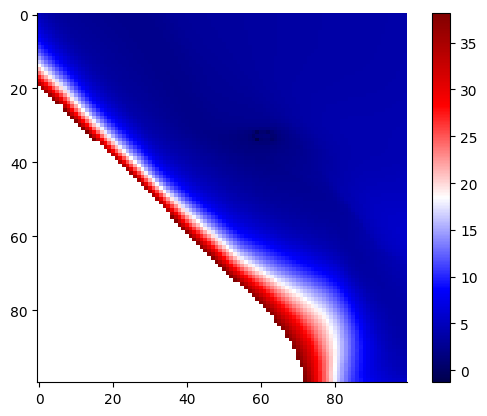

In [161]:
plt.figure()

plt.imshow(np.log10(np.abs(ll_value)), cmap='seismic')
plt.colorbar()
plt.show()

In [162]:
def log_probability(thetas):
    theta_1, theta_2 = thetas
    if theta_1 < 0.5 or theta_1 > 80 or theta_2 < 1e-4 or theta_2 > 15:
        return -np.inf
    return log_prob(thetas.reshape(-1, 2))

In [163]:
import emcee

ndim = 2
nwalkers = 12
nsteps = 10000

initial = np.random.rand(nwalkers, ndim)*0.1 + np.array([48.0, 8.0])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(initial, nsteps, progress=True)

  0%|          | 12/10000 [00:09<2:06:24,  1.32it/s]Traceback (most recent call last):
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_47394/3169717321.py", line 5, in log_probability
    return log_prob(thetas.reshape(-1, 2))
  File "/tmp/ipykernel_47394/1537669380.py", line 2, in log_prob
    return model.log_prob(((observation_summary_statistics.reshape(-1, 7)-xs_mean)/xs_std)*jnp.ones((len(thetas), 1)), (thetas-thetas_mean)/thetas_std)
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/flax/linen/module.py", line 694, in wrapped_module_method
    return self._call_wrapped_method(fun, args, kwargs)
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/flax/linen/module.py", line 1226, in _call_wrapped_method
    y = run_fun(self, *args, **kwargs)
  File "/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packa

emcee: Exception while calling your likelihood function:
  params: [48.26557729  8.07845152]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

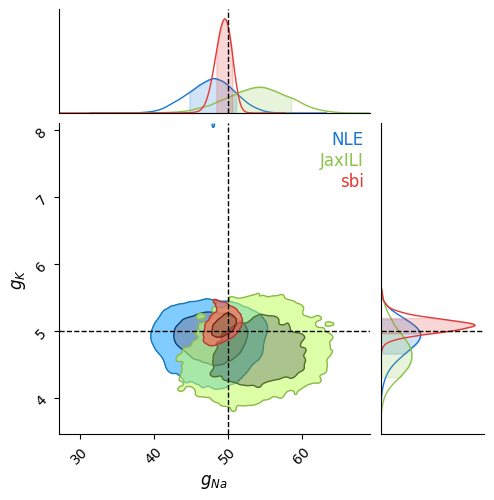

In [122]:
samples_nle = sampler.get_chain(flat=True)

c = ChainConsumer()
c.add_chain(samples_nle, parameters=labels_params, name="NLE")
c.add_chain(jaxili_samples*thetas_std+thetas_mean, parameters=labels_params, name="JaxILI")
c.add_chain(samples.numpy(), parameters=labels_params, name="sbi")
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()